In [1]:
import os
import scipy.io
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import random

# Load training data from MAT file
R = scipy.io.loadmat('movie_data/movie_train.mat')['train']

# Load validation data from CSV
val_data = np.loadtxt('movie_data/movie_validate.txt', dtype=int, delimiter=',')

In [2]:
# Helper method to get training accuracy
def get_train_acc(R, user_vecs, movie_vecs):
    num_correct, total = 0, 0
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if not np.isnan(R[i, j]):
                total += 1
                if np.dot(user_vecs[i], movie_vecs[j])*R[i, j] > 0:
                    num_correct += 1
    return num_correct/total

In [3]:
# Helper method to get validation accuracy
def get_val_acc(val_data, user_vecs, movie_vecs):
    num_correct = 0
    for val_pt in val_data:
        user_vec = user_vecs[val_pt[0]-1]
        movie_vec = movie_vecs[val_pt[1]-1]
        est_rating = np.dot(user_vec, movie_vec)
        if est_rating*val_pt[2] > 0:
            num_correct += 1
    return num_correct/val_data.shape[0]

In [4]:
# Helper method to get indices of all rated movies for each user,
# and indices of all users who have rated that title for each movie
def get_rated_idxs(R):
    user_rated_idxs, movie_rated_idxs = [], []
    for i in range(R.shape[0]):
        user_rated_idxs.append(np.argwhere(~np.isnan(R[i, :])).reshape(-1))
    for j in range(R.shape[1]):
        movie_rated_idxs.append(np.argwhere(~np.isnan(R[:, j])).reshape(-1))
    return np.array(user_rated_idxs, dtype=object), np.array(movie_rated_idxs, dtype=object)

In [5]:
# Part (c): SVD to learn low-dimensional vector representations
def svd_lfm(R):

    # Fill in the missing values in R
    ##### TODO(c): Your Code Here #####
    R = np.nan_to_num(R)

    # Compute the SVD of R
    ##### TODO(c): Your Code Here #####
    U, S, V = scipy.linalg.svd(R, full_matrices = False)

    # Construct user and movie representations
    ##### TODO(c): Your Code Here #####

    user_vecs = U * S

    movie_vecs = V.T
    
    return user_vecs, movie_vecs

In [6]:
# Part (d): Compute the training MSE loss of a given vectorization
def get_train_mse(R, user_vecs, movie_vecs):
    
    mse_loss = 0
    # Compute the training MSE loss
    ##### TODO(d): Your Code Here #####
    for user in range(R.shape[0]):
        for movie in range(R.shape[1]):
            if not(np.isnan(R[user][movie])):
                mse_loss += (np.dot(user_vecs[user], movie_vecs[movie]) - R[user][movie])**2

    return mse_loss

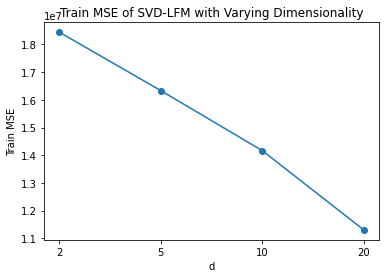

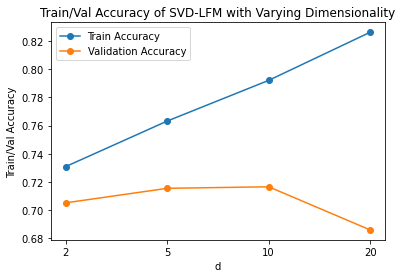

In [7]:
# Part (e): Compute training MSE and val acc of SVD LFM for various d
d_values = [2, 5, 10, 20]
train_mses, train_accs, val_accs = [], [], []
user_vecs, movie_vecs = svd_lfm(np.copy(R))

for d in d_values:
    train_mses.append(get_train_mse(np.copy(R), user_vecs[:, :d], movie_vecs[:, :d]))
    train_accs.append(get_train_acc(np.copy(R), user_vecs[:, :d], movie_vecs[:, :d]))
    val_accs.append(get_val_acc(val_data, user_vecs[:, :d], movie_vecs[:, :d]))
    
plt.clf()
plt.plot([str(d) for d in d_values], train_mses, 'o-')
plt.title('Train MSE of SVD-LFM with Varying Dimensionality')
plt.xlabel('d')
plt.ylabel('Train MSE')
plt.savefig(fname='train_mses.png', dpi=600, bbox_inches='tight')
plt.show()

plt.clf()
plt.plot([str(d) for d in d_values], train_accs, 'o-')
plt.plot([str(d) for d in d_values], val_accs, 'o-')
plt.title('Train/Val Accuracy of SVD-LFM with Varying Dimensionality')
plt.xlabel('d')
plt.ylabel('Train/Val Accuracy')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.savefig(fname='trval_accs.png', dpi=600, bbox_inches='tight')
plt.show()

## d = 10 produces optimal performance. The top 10 features produce the best validation accuracy and help prevent overfitting. 

In [8]:
# Part (f): Learn better user/movie vector representations by minimizing loss
# begin solution
best_d = 10 # TODO(f): Use best from part (e)
# end solution
np.random.seed(20)
user_vecs = np.random.random((R.shape[0], best_d))
movie_vecs = np.random.random((R.shape[1], best_d))
user_rated_idxs, movie_rated_idxs = get_rated_idxs(np.copy(R))

# Part (f): Function to update user vectors
def update_user_vecs(user_vecs, movie_vecs, R, user_rated_idxs):

    # Update user_vecs to the loss-minimizing value
    ##### TODO(f): Your Code Here #####
    users = R.shape[0]
    
    for i in range(users):
        first = np.identity(best_d)
        second = np.zeros((best_d, ))
        for j in user_rated_idxs[i]:
            first += np.outer(movie_vecs[j], movie_vecs[j])
            second += R[i][j] * movie_vecs[j]
        user_vecs[i] = np.dot(np.linalg.inv(first), second)
        
    return user_vecs
# Part (f): Function to update user vectors
def update_movie_vecs(user_vecs, movie_vecs, R, movie_rated_idxs):

    # Update movie_vecs to the loss-minimizing value
    ##### TODO(f): Your Code Here #####
    movies = R.shape[1]
    
    for j in range(movies):
        first = np.identity(best_d)
        second = np.zeros((best_d, ))
        for i in movie_rated_idxs[j]:
            first += np.outer(user_vecs[i], user_vecs[i])
            second += R[i][j] * user_vecs[i]
        movie_vecs[j] = np.dot(np.linalg.inv(first), second)
        
    return movie_vecs


# Part (f): Perform loss optimization using alternating updates
train_mse = get_train_mse(np.copy(R), user_vecs, movie_vecs)
train_acc = get_train_acc(np.copy(R), user_vecs, movie_vecs)
val_acc = get_val_acc(val_data, user_vecs, movie_vecs)
print(f'Start optim, train MSE: {train_mse:.2f}, train accuracy: {train_acc:.4f}, val accuracy: {val_acc:.4f}')
for opt_iter in range(20):
    user_vecs = update_user_vecs(user_vecs, movie_vecs, np.copy(R), user_rated_idxs)
    movie_vecs = update_movie_vecs(user_vecs, movie_vecs, np.copy(R), movie_rated_idxs)
    train_mse = get_train_mse(np.copy(R), user_vecs, movie_vecs)
    train_acc = get_train_acc(np.copy(R), user_vecs, movie_vecs)
    val_acc = get_val_acc(val_data, user_vecs, movie_vecs)
    print(f'Iteration {opt_iter+1}, train MSE: {train_mse:.2f}, train accuracy: {train_acc:.4f}, val accuracy: {val_acc:.4f}')


Start optim, train MSE: 27574866.30, train accuracy: 0.5950, val accuracy: 0.5799
Iteration 1, train MSE: 13421216.24, train accuracy: 0.7611, val accuracy: 0.6431
Iteration 2, train MSE: 11474959.41, train accuracy: 0.7876, val accuracy: 0.6789
Iteration 3, train MSE: 10493324.86, train accuracy: 0.8007, val accuracy: 0.6989
Iteration 4, train MSE: 10040997.98, train accuracy: 0.8069, val accuracy: 0.7084
Iteration 5, train MSE: 9792296.83, train accuracy: 0.8098, val accuracy: 0.7100
Iteration 6, train MSE: 9649312.88, train accuracy: 0.8117, val accuracy: 0.7100
Iteration 7, train MSE: 9561491.69, train accuracy: 0.8130, val accuracy: 0.7060
Iteration 8, train MSE: 9503837.41, train accuracy: 0.8138, val accuracy: 0.7117
Iteration 9, train MSE: 9463660.97, train accuracy: 0.8144, val accuracy: 0.7111
Iteration 10, train MSE: 9434168.95, train accuracy: 0.8147, val accuracy: 0.7087
Iteration 11, train MSE: 9411512.64, train accuracy: 0.8150, val accuracy: 0.7119
Iteration 12, train M

## Our best run was iteration 20 with a train MSE: 9314221.76, train accuracy: 81.63%, val accuracy: 71.6%. These values were slightly better than the train and validation accuracies of part e.).